<center><h1>Making Merger Tree from m3p output</h1></center>

In [1]:
import numpy as np
import m3p_merger
import matplotlib.pyplot as plt
import importlib
import matplotlib

In [2]:
Omega_m0 = 0.3
Omega_r0 = 8.486e-5
h = 0.7

G = 6.674e-11 # m^3 kg^(-1) s^(-2)
Mpc = 3.086e22 # m 
Msol = 1.988e30 # kg
Mpcpkm = (1e3/3.0869e22)
H = 100*Mpcpkm*h # /s
Omega_DM = 0.267

rho_c = 3/(8*np.pi*G)*Mpc**3/Msol*H**2 # Msol / Mpc^(-3)
rho_bg = 0.267*rho_c

z_eq = Omega_m0/Omega_r0 - 1
a_eq = 1/(1+z_eq)


In [3]:
# Peak patch data
pathPrefix = "/usr/users/ellis/PeakPatch/m3p/axOut/"

In [4]:
#ppFile = pathPrefix + "../inputs/inputs.ax1"
ppFile = pathPrefix + "../inputs/inputs.ax_new"

peak_list, boxsize = m3p_merger.MakePeakList(ppFile, printOutput = True)

	Loading file (0 of 11): /usr/users/ellis/PeakPatch/m3p/axOut/axion_new_final_halos_0.hdf5
	Loading file (1 of 11): /usr/users/ellis/PeakPatch/m3p/axOut/axion_new_final_halos_1.hdf5
	Loading file (2 of 11): /usr/users/ellis/PeakPatch/m3p/axOut/axion_new_final_halos_2.hdf5
	Loading file (3 of 11): /usr/users/ellis/PeakPatch/m3p/axOut/axion_new_final_halos_3.hdf5
	Loading file (4 of 11): /usr/users/ellis/PeakPatch/m3p/axOut/axion_new_final_halos_4.hdf5
	Loading file (5 of 11): /usr/users/ellis/PeakPatch/m3p/axOut/axion_new_final_halos_5.hdf5
	Loading file (6 of 11): /usr/users/ellis/PeakPatch/m3p/axOut/axion_new_final_halos_6.hdf5
	Loading file (7 of 11): /usr/users/ellis/PeakPatch/m3p/axOut/axion_new_final_halos_7.hdf5
	Loading file (8 of 11): /usr/users/ellis/PeakPatch/m3p/axOut/axion_new_final_halos_8.hdf5
	Loading file (9 of 11): /usr/users/ellis/PeakPatch/m3p/axOut/axion_new_final_halos_9.hdf5
	Loading file (10 of 11): /usr/users/ellis/PeakPatch/m3p/axOut/axion_new_final_halos_10.hd

In [ ]:
peak_list.shape

<h2><center>Find which trees are interesting</center></h2>

In [ ]:
for i in range(len(peak_list[0].T)):
    out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = i)
    if len(out[0][5]) > 1:
        print(i)

<h2><center>Calculate Merger Tree</center></h2>

In [ ]:
importlib.reload(m3p_merger)
#indicies = np.arange(1000)
out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = 3)

<h2><center>Plot all peaks on each other</center></h2>

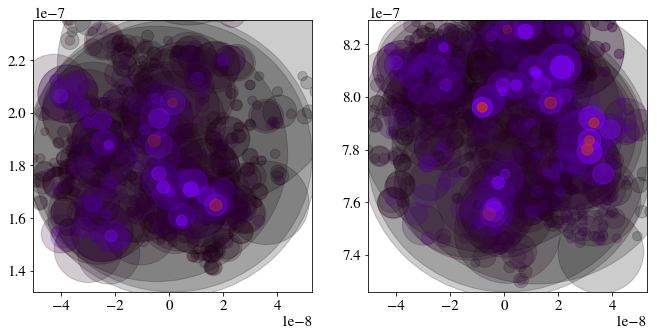

In [5]:
out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = 3)
m3p_merger.plotMergerPatches(out[0], ppFile)

<h2><center>Plot merger tree</center></h2>

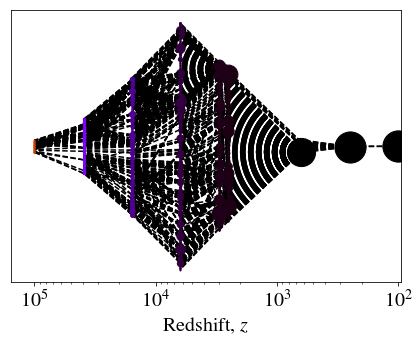

In [6]:
importlib.reload(m3p_merger)
m3p_merger.plotMergerTree(out[0], ppFile, font_size = 20, log = True)
#plt.savefig("MergerTree.pdf")

In [ ]:
# Calculate 
f = np.logspace(-2, 0)
zcol = [m3p_merger.FindCollapseRedshift(out[0], f[i], ppFile) for i in range(len(f))]

plt.semilogx(f, zcol,lw = 3)
plt.ylabel("Collapse redshift $z_{\mathrm{col}}$ ")
plt.xlabel("$f$")